In [ ]:
#| default_exp design

In [ ]:
#| include: false
import sys; sys.path.insert(0, '..') # make sure rust binary can be found...

In [ ]:
#| exporti
from typing import NamedTuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from fastcore.basics import patch_to
from inverse_design.brushes import notched_square_brush, show_mask
from inverse_design.utils import batch_conv2d, dilute
from matplotlib.colors import ListedColormap

In [ ]:
#| exports
UNASSIGNED = 0
VOID = 1
SOLID = 2
PIXEL_IMPOSSIBLE = 3
PIXEL_EXISTING = 4
PIXEL_POSSIBLE = 5
PIXEL_REQUIRED = 6
TOUCH_REQUIRED = 7
TOUCH_INVALID = 8
TOUCH_EXISTING = 9
TOUCH_VALID = 10
TOUCH_FREE = 11
TOUCH_RESOLVING = 12

In [ ]:
#| export
class Design(NamedTuple):
    void_pixels: jnp.ndarray
    solid_pixels: jnp.ndarray
    void_touches: jnp.ndarray
    solid_touches: jnp.ndarray

    @property
    def shape(self):
        return self.void_pixels.shape

    @property
    def design(self):
        design = UNASSIGNED * jnp.ones(self.shape, dtype=jnp.uint8)
        design = jnp.where(self.void_pixels == PIXEL_EXISTING, VOID, design)
        design = jnp.where(self.solid_pixels == PIXEL_EXISTING, SOLID, design)
        return design

    def copy(self, **kwargs):
        kwargs = {name: kwargs.get(name, getattr(self, name)) for name in self._fields}
        return Design(*kwargs.values())

In [ ]:
#| export
def new_design(shape):
    return Design(
        void_pixels=jnp.zeros(shape, dtype=jnp.uint8).at[:,:].set(PIXEL_POSSIBLE),
        solid_pixels=jnp.zeros(shape, dtype=jnp.uint8).at[:,:].set(PIXEL_POSSIBLE),
        void_touches=jnp.zeros(shape, dtype=jnp.uint8).at[:,:].set(TOUCH_VALID),
        solid_touches=jnp.zeros(shape, dtype=jnp.uint8).at[:,:].set(TOUCH_VALID),
    )

In [ ]:
#| export
def design_mask(design, dtype=float):
    one = jnp.ones_like(design.design, dtype=dtype)
    mask = jnp.where(design.design == VOID, -1, one)
    return mask

In [ ]:
#| export


def visualize(design):
    _cmap = ListedColormap(colors={UNASSIGNED: "#929292", VOID: "#cbcbcb", SOLID: "#515151", PIXEL_IMPOSSIBLE: "#8dd3c7", PIXEL_EXISTING: "#ffffb3", PIXEL_POSSIBLE: "#bebada", PIXEL_REQUIRED: "#fb7f72", TOUCH_REQUIRED: "#00ff00", TOUCH_INVALID: "#7fb1d3", TOUCH_EXISTING: "#fdb462", TOUCH_VALID: "#b3de69", TOUCH_FREE: "#fccde5", TOUCH_RESOLVING: "#e0e0e0"}.values(), name="cmap")
    nx, ny = design.design.shape
    _, axs = plt.subplots(1, 5, figsize=(15,3*nx/ny))
    for i, name in enumerate(["design", *design._fields]):
        ax = axs[i]
        ax.set_title(name.replace("_", " "))
        ax.imshow(getattr(design, name), cmap=_cmap, vmin=UNASSIGNED, vmax=TOUCH_RESOLVING)
        ax.set_yticks(jnp.arange(nx)+0.5)
        ax.set_yticklabels(["" for i in range(nx)])
        ax.set_xticks(jnp.arange(ny)+0.5)
        ax.set_xticklabels(["" for i in range(ny)])
        ax.set_yticks(jnp.arange(nx), minor=True)
        ax.set_yticklabels([f"{i}" for i in range(nx)], minor=True)
        ax.set_xticks(jnp.arange(ny), minor=True)
        ax.set_xticklabels([f"{i}" for i in range(ny)], minor=True)
        ax.set_xlim(-0.5, ny-0.5)
        ax.set_ylim(nx-0.5, -0.5)
        ax.grid(visible=True, which="major", c="k")

@patch_to(Design)
def _repr_html_(self):
    visualize(self)
    return ""

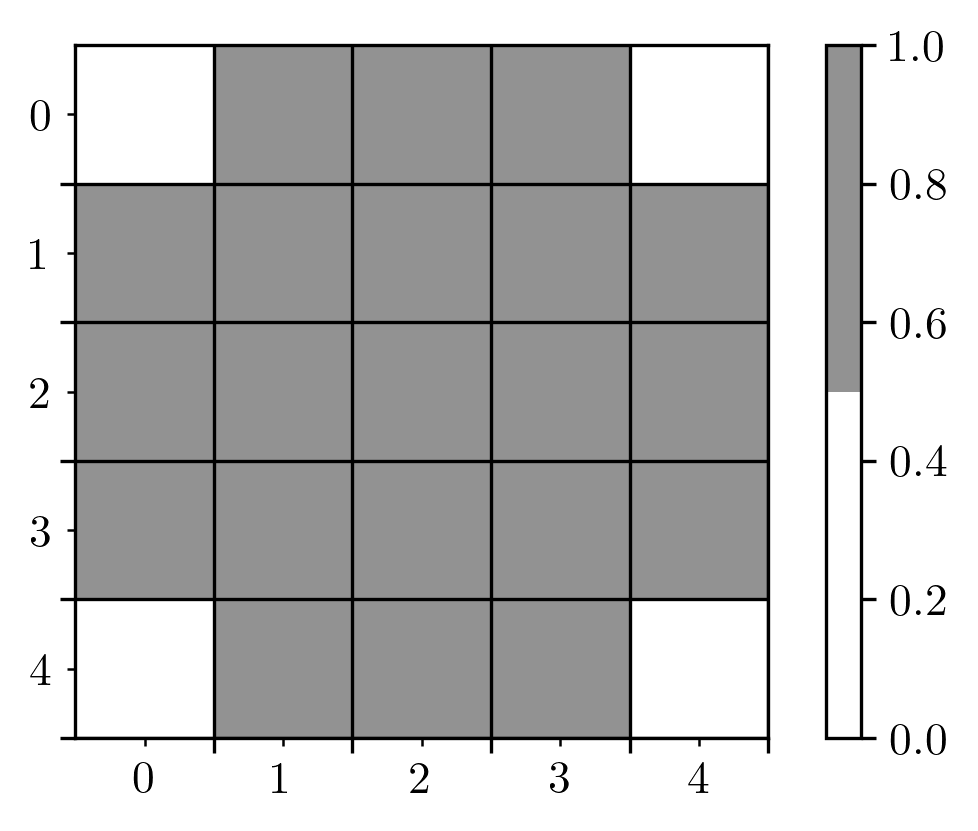

In [ ]:
my_brush = notched_square_brush(5, 1)
show_mask(my_brush)

Design(void_pixels=Array([[5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), solid_pixels=Array([[5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), void_touches=Array([[10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8), solid_touches=Array([[10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8))

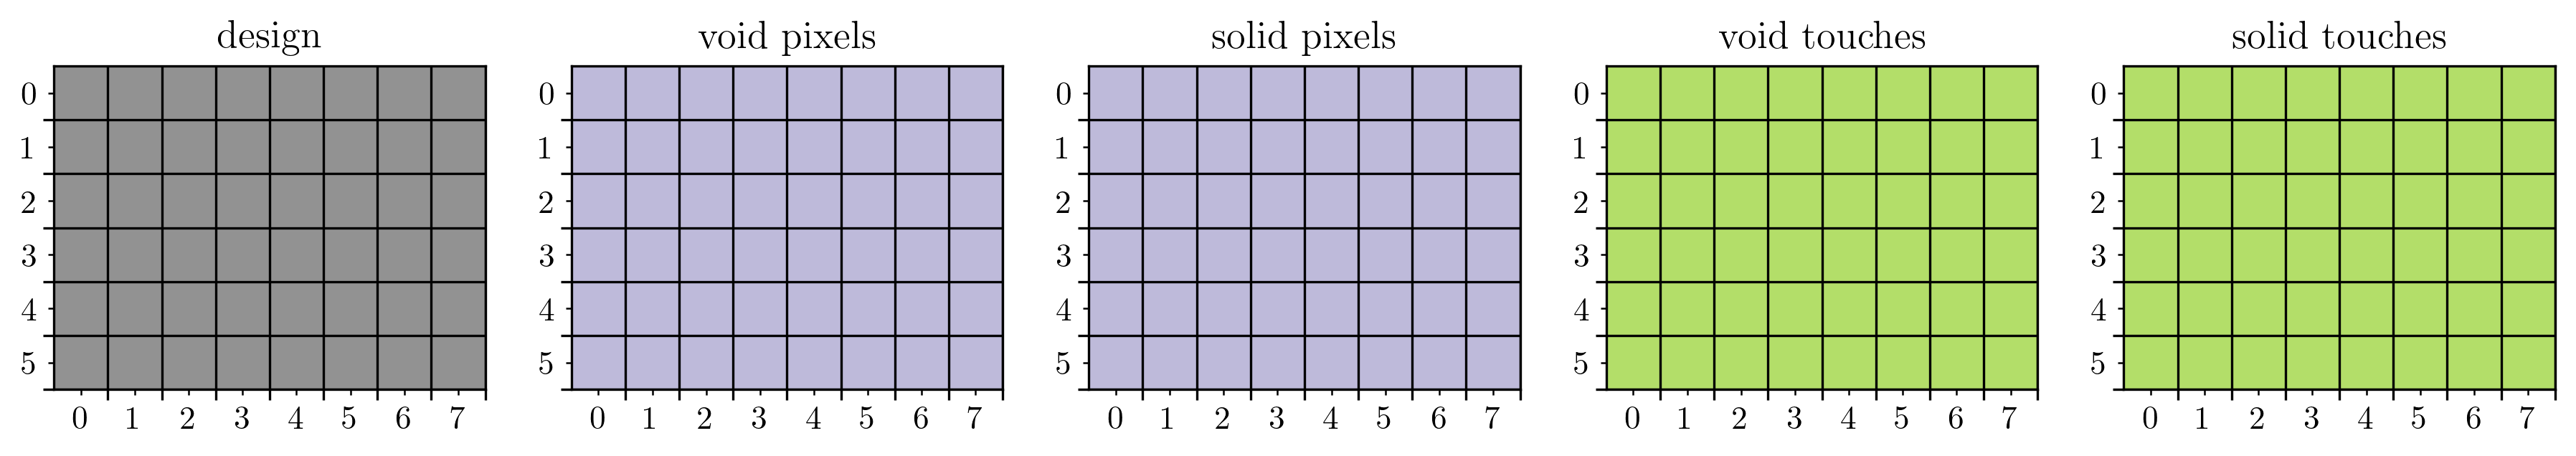

In [ ]:
step1 = lambda: new_design((6, 8))
step1()

In [ ]:
#| exporti
@jax.jit
def _find_free_touches(touches_mask, pixels_mask, brush):
    r = jnp.zeros_like(touches_mask, dtype=bool)
    m, n = r.shape
    i, j = jnp.arange(m), jnp.arange(n)
    I, J = [idxs.ravel() for idxs in jnp.meshgrid(i, j)]
    K = jnp.arange(m * n)
    R = jnp.broadcast_to(r[None, :, :], (m * n, m, n)).at[K, I, J].set(True)
    Rb = batch_conv2d(R, brush[None]) | pixels_mask
    free_idxs = (Rb == pixels_mask).all((1, 2))
    free_touches_mask = jnp.where(free_idxs[:, None, None], R, 0).sum(0, dtype=bool)
    return free_touches_mask ^ touches_mask


@jax.jit
def _find_free_touches_alternative(touches_mask, pixels_mask, brush):
    brush_u32 = jnp.asarray(brush, dtype=jnp.uint32)
    sum_mask = dilute(jnp.asarray(pixels_mask, dtype=jnp.uint32), brush_u32)
    ref_mask = dilute(jnp.ones_like(sum_mask), brush_u32)
    free_mask = sum_mask == ref_mask
    free_mask = free_mask & (~touches_mask)
    return free_mask

In [ ]:
#| exporti
@jax.jit
def _find_required_pixels(pixel_map, brush):
    mask = (~pixel_map) & (~dilute(pixel_map, brush))
    return ~(dilute(mask, brush) | pixel_map)

In [ ]:
#| export
@jax.jit
def add_void_touch(design, brush, pos):
    if isinstance(pos, tuple):
        void_touch_existing = design.void_touches.at[pos[0], pos[1]].set(TOUCH_EXISTING) == TOUCH_EXISTING
    else:
        assert pos.dtype == bool
        void_touch_existing = pos | (design.void_touches == TOUCH_EXISTING)
    void_pixel_existing = dilute(void_touch_existing, brush) | (design.void_pixels == PIXEL_EXISTING)
    void_pixel_required = _find_required_pixels(void_pixel_existing, brush)
    solid_touch_invalid = dilute(void_pixel_existing, brush)
    void_touch_free = _find_free_touches(void_touch_existing, void_pixel_existing | void_pixel_required, brush)
    void_touches = jnp.where(design.void_touches == TOUCH_RESOLVING, TOUCH_VALID, design.void_touches)
    void_touches = jnp.where(void_touch_existing, TOUCH_EXISTING, void_touches)
    void_touches = jnp.where(void_touch_free, TOUCH_FREE, void_touches)
    void_touch_resolving = jnp.where(void_touches == TOUCH_VALID, dilute(void_pixel_required, brush), False)
    void_touches = jnp.where(void_touch_resolving, TOUCH_RESOLVING, void_touches)
    void_pixels = jnp.where(void_pixel_existing, PIXEL_EXISTING, design.void_pixels)
    void_pixels = jnp.where(void_pixel_required, PIXEL_REQUIRED, void_pixels)
    solid_pixels =  jnp.where(void_pixel_existing, PIXEL_IMPOSSIBLE, design.solid_pixels)
    solid_pixels = jnp.where(void_pixel_required, PIXEL_IMPOSSIBLE, solid_pixels)
    solid_touches = jnp.where(solid_touch_invalid, TOUCH_INVALID, design.solid_touches)
    return Design(void_pixels, solid_pixels, void_touches, solid_touches)

Design(void_pixels=Array([[5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), solid_pixels=Array([[5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 5, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), void_touches=Array([[10, 10, 10, 10, 10, 10,  9, 11],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8), solid_touches=Array([[10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10, 10,  8,  8,  8,  8,  8],
       [10, 10, 10, 10,  8,  8,  8,  8],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8))

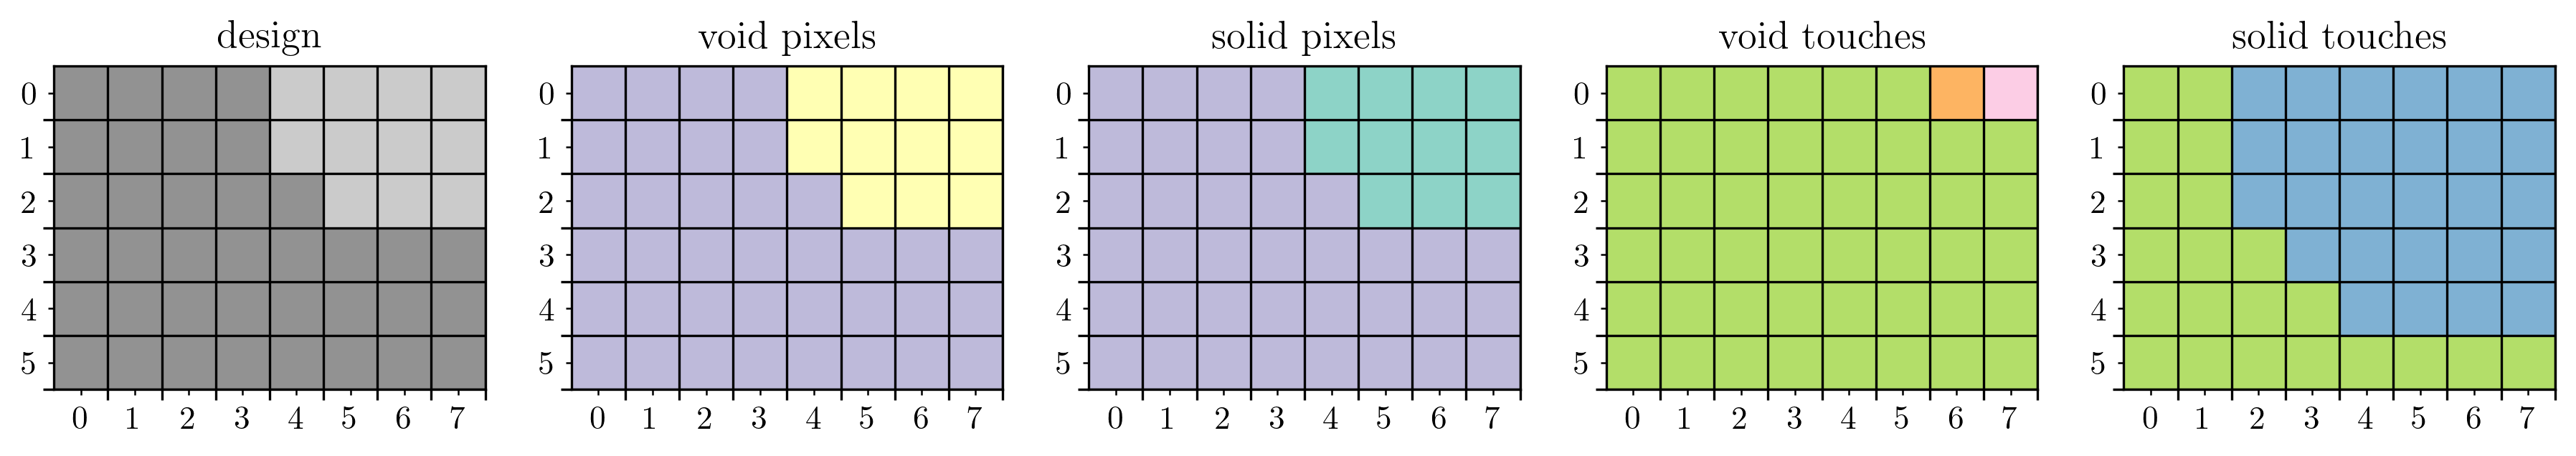

In [ ]:
step2 = lambda: add_void_touch(step1(), my_brush, (0, 6))
step2()

In [ ]:
#| export
@jax.jit
def take_free_void_touches(design, brush):
    free_touches_mask = design.void_touches == TOUCH_FREE
    return add_void_touch(design, brush, free_touches_mask)

Design(void_pixels=Array([[5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), solid_pixels=Array([[5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 5, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), void_touches=Array([[10, 10, 10, 10, 10, 10,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8), solid_touches=Array([[10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10, 10,  8,  8,  8,  8,  8],
       [10, 10, 10, 10,  8,  8,  8,  8],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8))

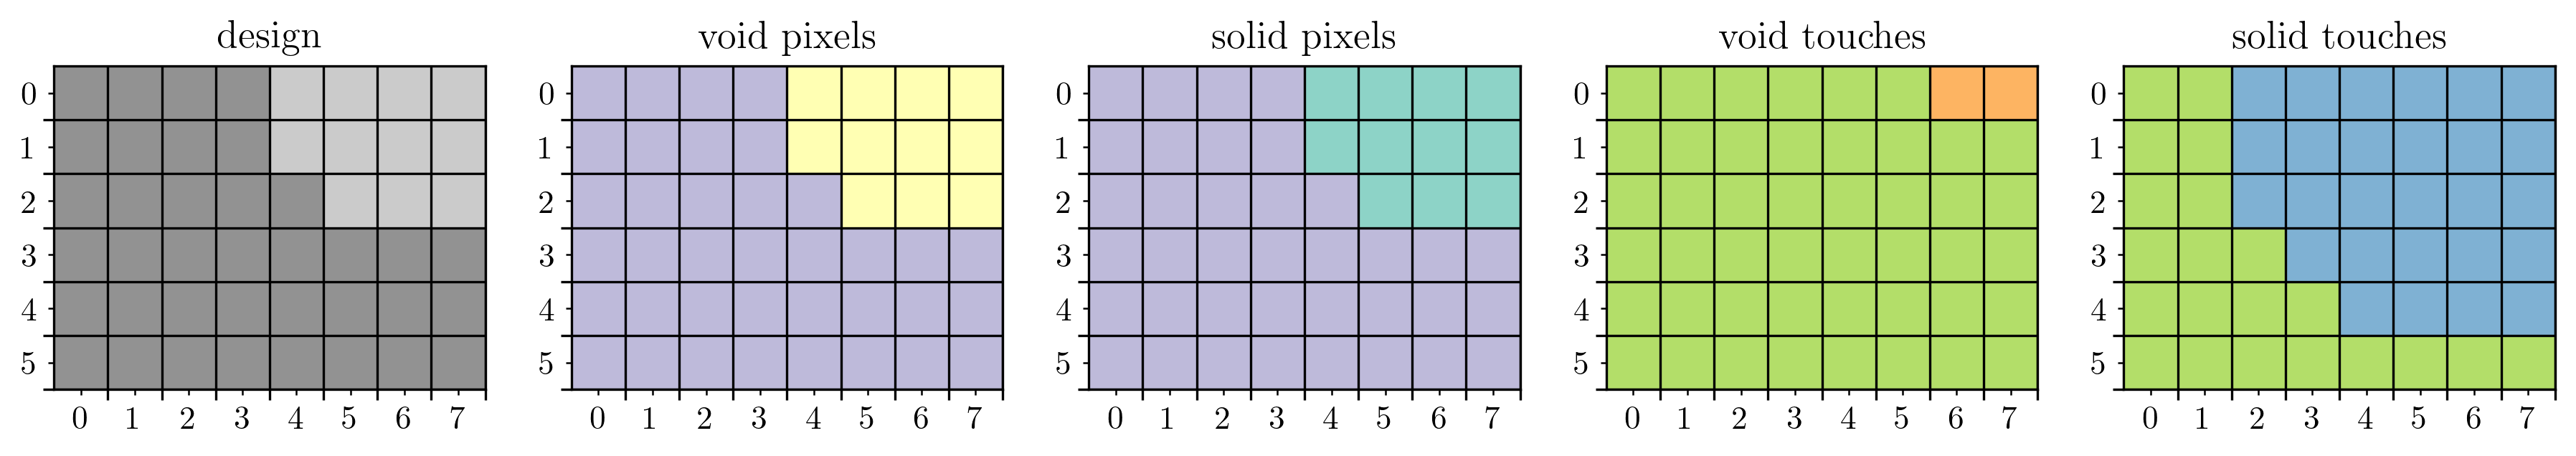

In [ ]:
step3 = lambda: take_free_void_touches(step2(), my_brush)
step3()

In [ ]:
#| export
def invert_design(design):
    return Design(design.solid_pixels, design.void_pixels, design.solid_touches, design.void_touches)

Design(void_pixels=Array([[5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 5, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), solid_pixels=Array([[5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), void_touches=Array([[10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10, 10,  8,  8,  8,  8,  8],
       [10, 10, 10, 10,  8,  8,  8,  8],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8), solid_touches=Array([[10, 10, 10, 10, 10, 10,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8))

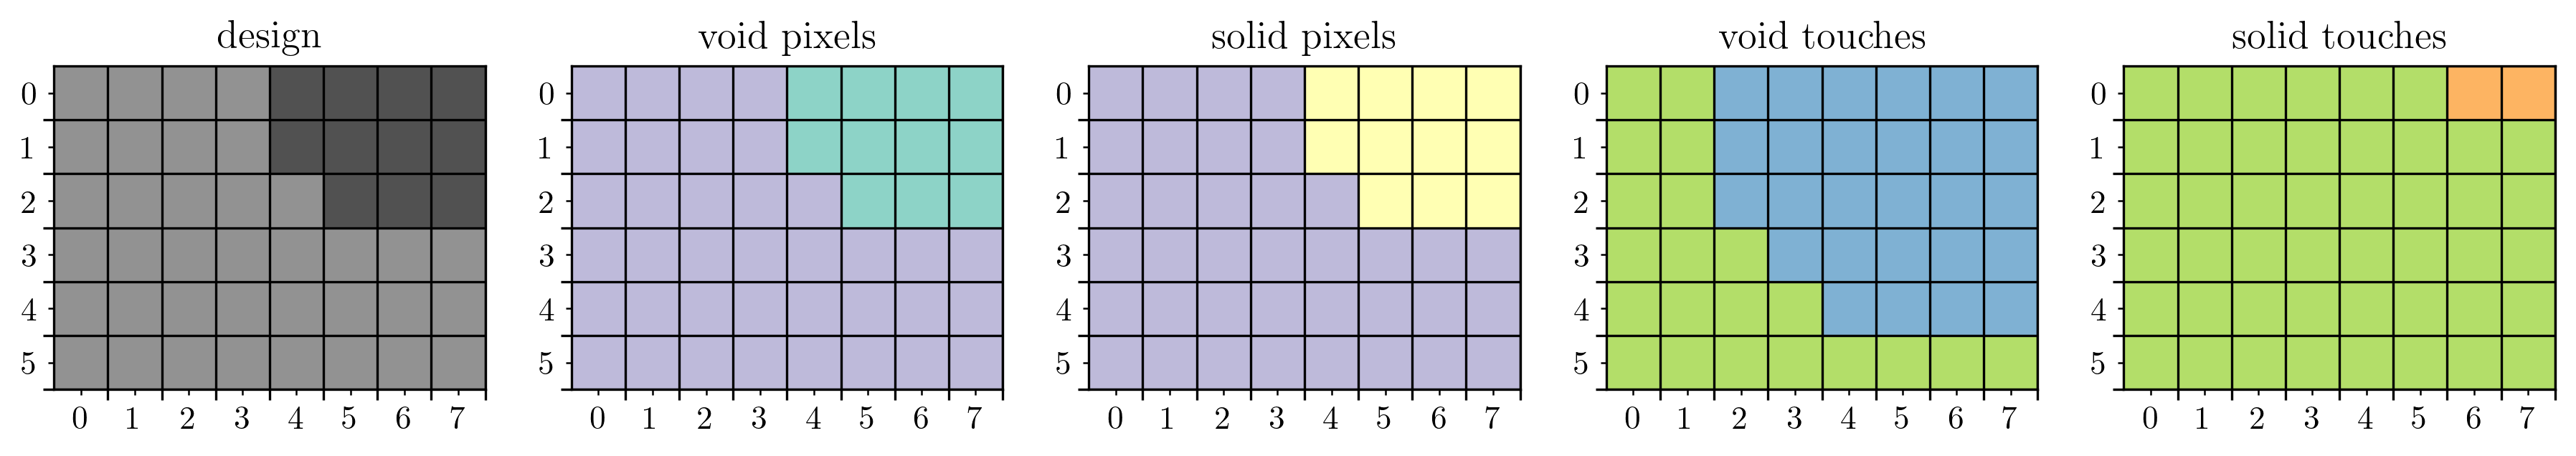

In [ ]:
invert_design(step3())

In [ ]:
#| export
@jax.jit
def add_solid_touch(design, brush, pos):
    inverted_design = invert_design(design)
    inverted_design = add_void_touch(inverted_design, brush, pos)
    design = invert_design(inverted_design)
    return design

In [ ]:
#| export
@jax.jit
def take_free_solid_touches(design, brush):
    free_touches_mask = design.solid_touches == TOUCH_FREE
    return add_solid_touch(design, brush, free_touches_mask)

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 5, 5, 4, 4, 4],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 5, 5, 3, 3, 3],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10, 10, 10],
       [ 8,  8,  8,  8,  8, 10, 10, 10],
       [ 8,  8,  8,  8, 10, 10, 10, 10],
       [ 8,  8,  8, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10, 10,  8,  8,  8,  8,  8],
       [10, 10, 10, 10,  8,  8,  8,  8],
       [10, 10, 10, 10, 10, 10, 10, 10]], dtype=uint8))

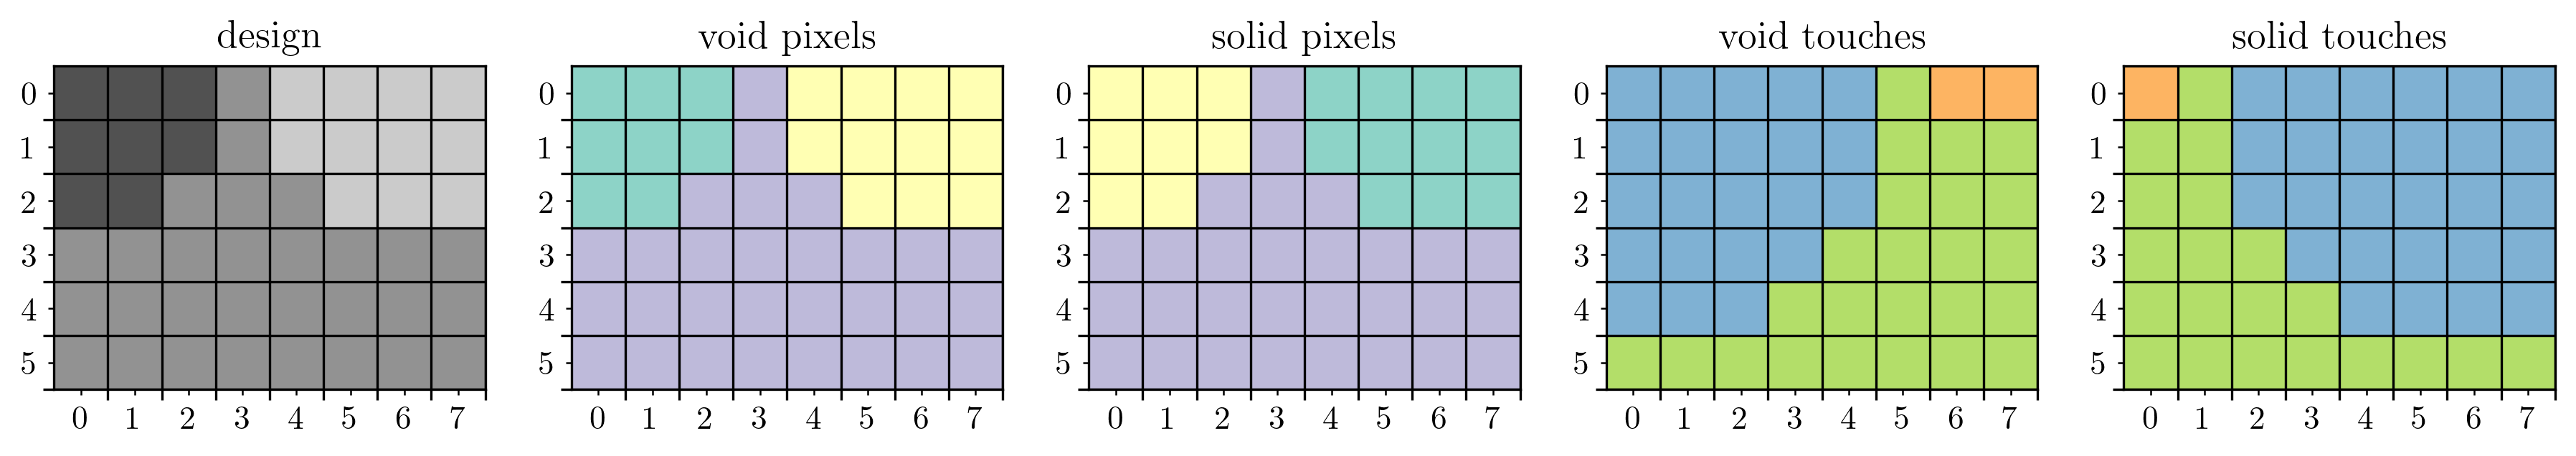

In [ ]:
step4 = lambda: add_solid_touch(step3(), my_brush, (0, 0))
step4()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 5, 6, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 12,  9,  9],
       [ 8,  8,  8,  8,  8, 12, 11, 11],
       [ 8,  8,  8,  8,  8, 12, 11, 11],
       [ 8,  8,  8,  8, 12, 12, 11, 11],
       [ 8,  8,  8, 12, 12, 12,  9, 11],
       [10, 10, 10, 10, 10, 10, 11, 11]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8]], dtype=uint8))

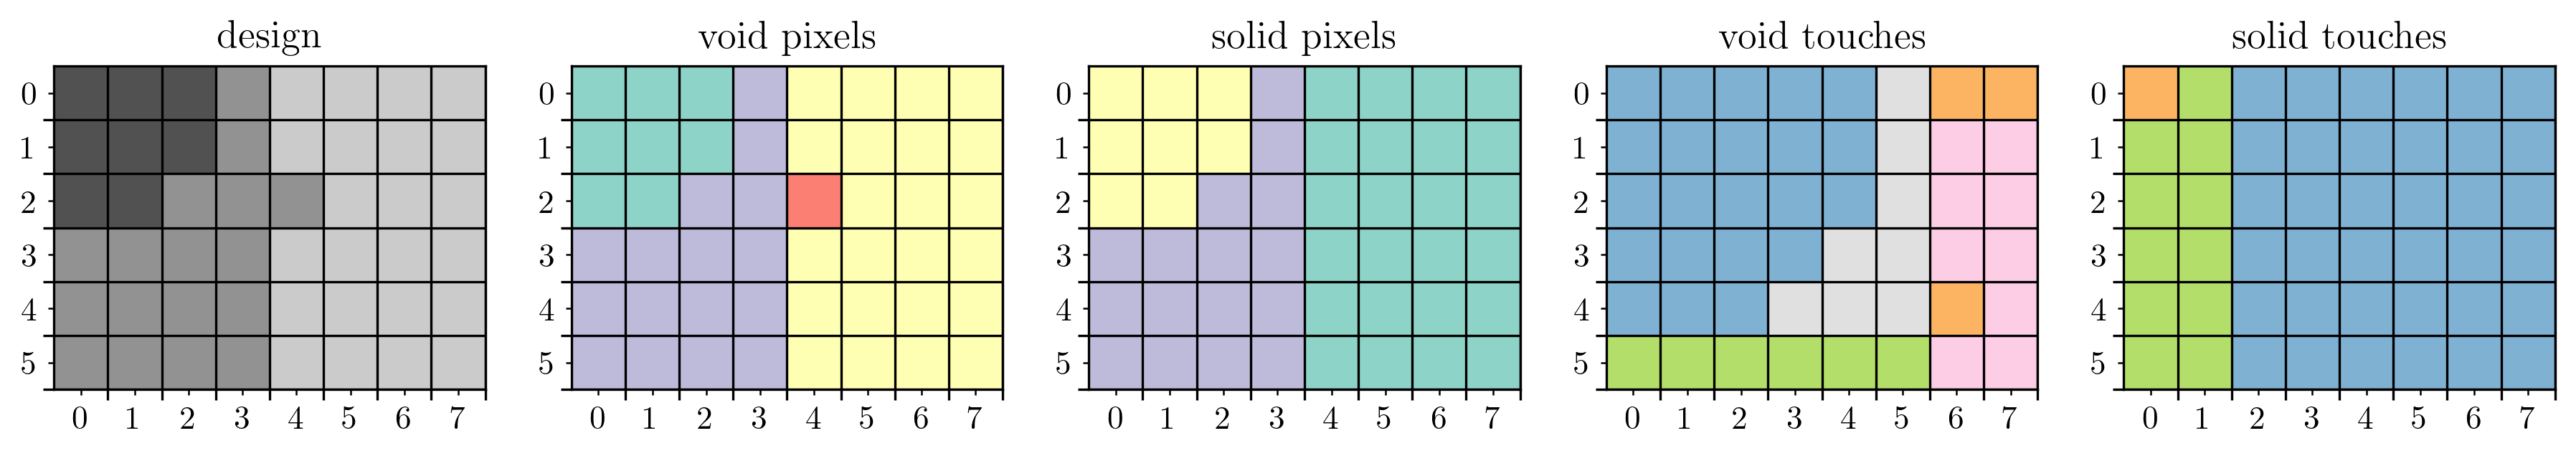

In [ ]:
step5 = lambda: add_void_touch(step4(), my_brush, (4, 6))
step5()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4],
       [5, 5, 5, 5, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3],
       [5, 5, 5, 5, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8, 10, 10,  9,  9],
       [ 8,  8,  8, 10, 10, 10,  9,  9],
       [10, 10, 10, 10, 10, 10,  9,  9]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8],
       [10, 10,  8,  8,  8,  8,  8,  8]], dtype=uint8))

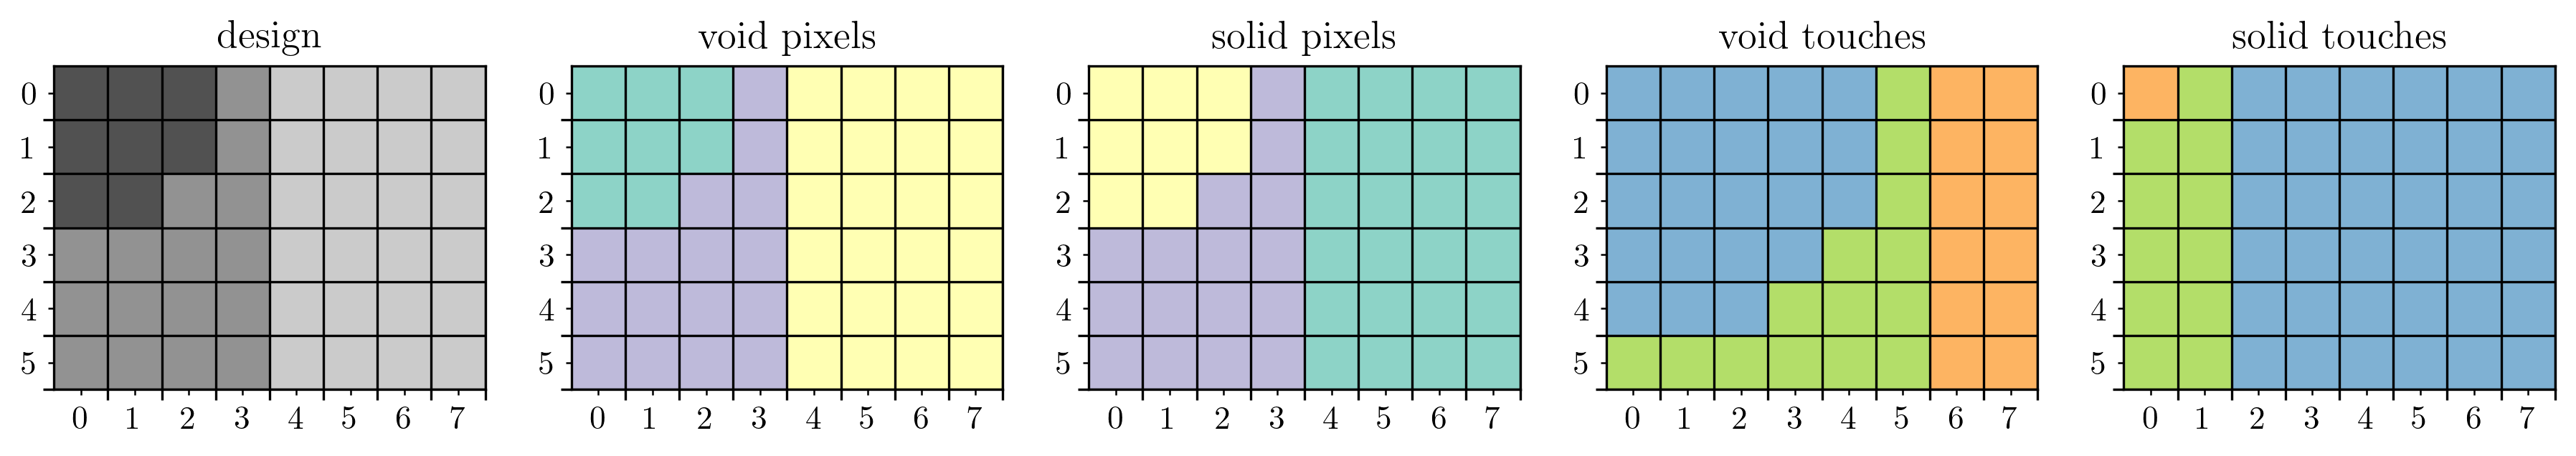

In [ ]:
step6 = lambda: take_free_void_touches(step5(), my_brush)
step6()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 4, 4, 4, 4, 4],
       [5, 5, 4, 4, 4, 4, 4, 4],
       [6, 6, 4, 4, 4, 4, 4, 4],
       [6, 6, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 3, 3, 3, 3, 3],
       [5, 5, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8, 10, 11,  9,  9],
       [ 8,  8,  8, 12,  9, 11,  9,  9],
       [12, 12, 12, 11, 11, 11,  9,  9]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [10,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8]], dtype=uint8))

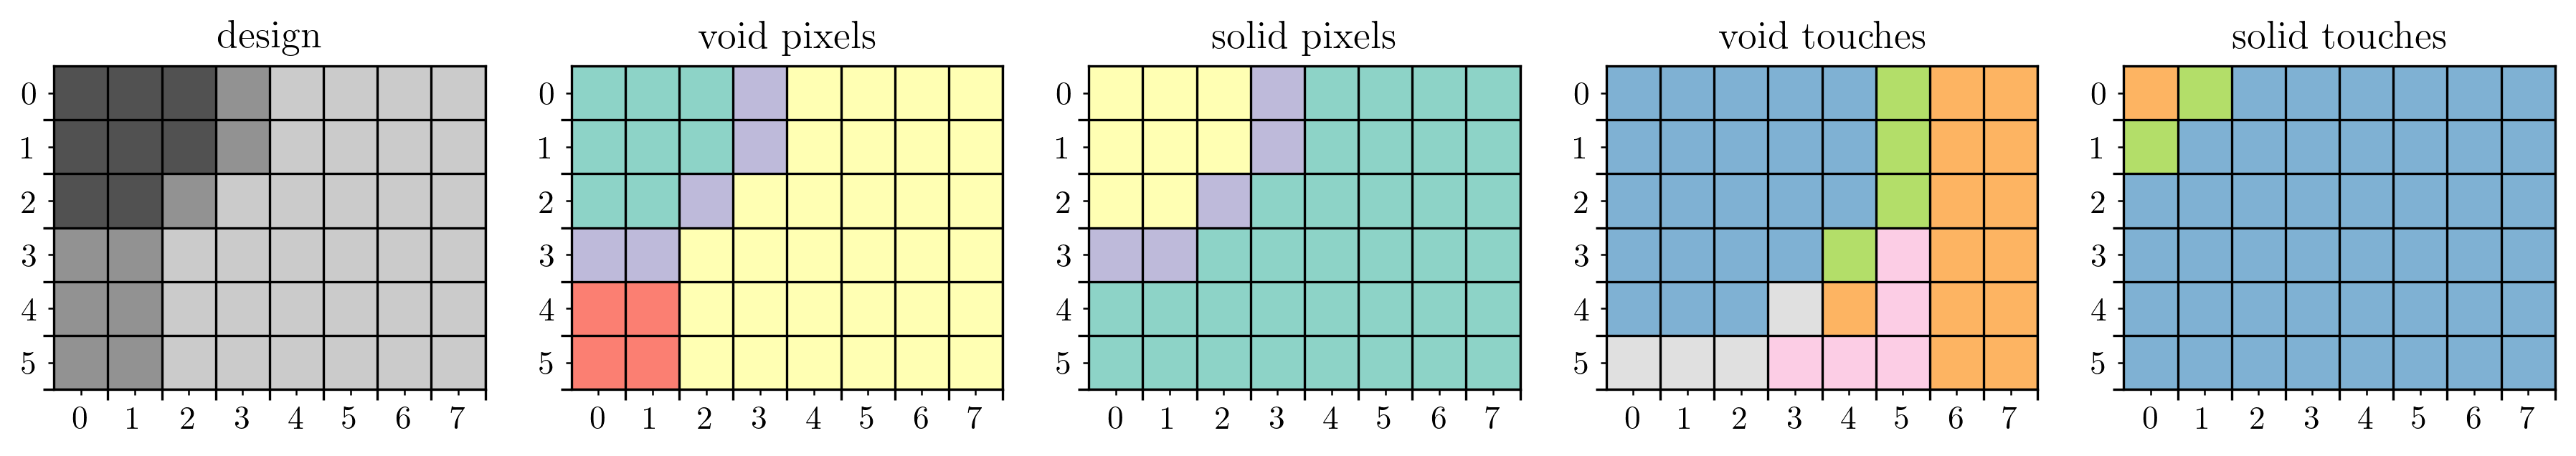

In [ ]:
step7 = lambda: add_void_touch(step6(), my_brush, (4, 4))
step7()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 4, 4, 4, 4, 4],
       [5, 5, 4, 4, 4, 4, 4, 4],
       [6, 4, 4, 4, 4, 4, 4, 4],
       [6, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 3, 3, 3, 3, 3],
       [5, 5, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8, 10,  9,  9,  9],
       [ 8,  8,  8, 10,  9,  9,  9,  9],
       [12, 12, 12,  9,  9,  9,  9,  9]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [10,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8]], dtype=uint8))

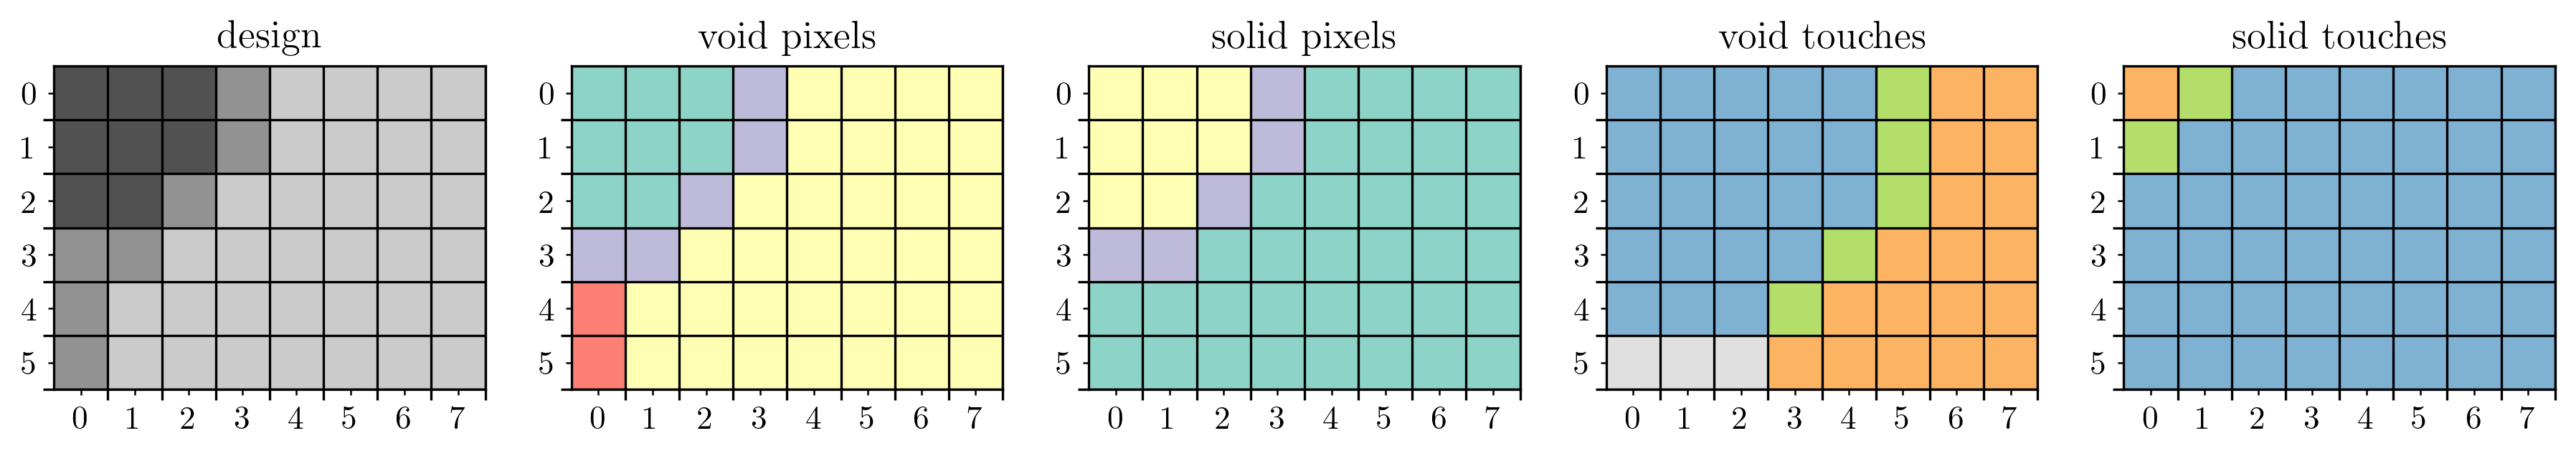

In [ ]:
step8 = lambda: take_free_void_touches(step7(), my_brush)
step8()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8, 10,  9,  9,  9],
       [ 8,  8,  8, 10,  9,  9,  9,  9],
       [ 9, 11, 11,  9,  9,  9,  9,  9]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8]], dtype=uint8))

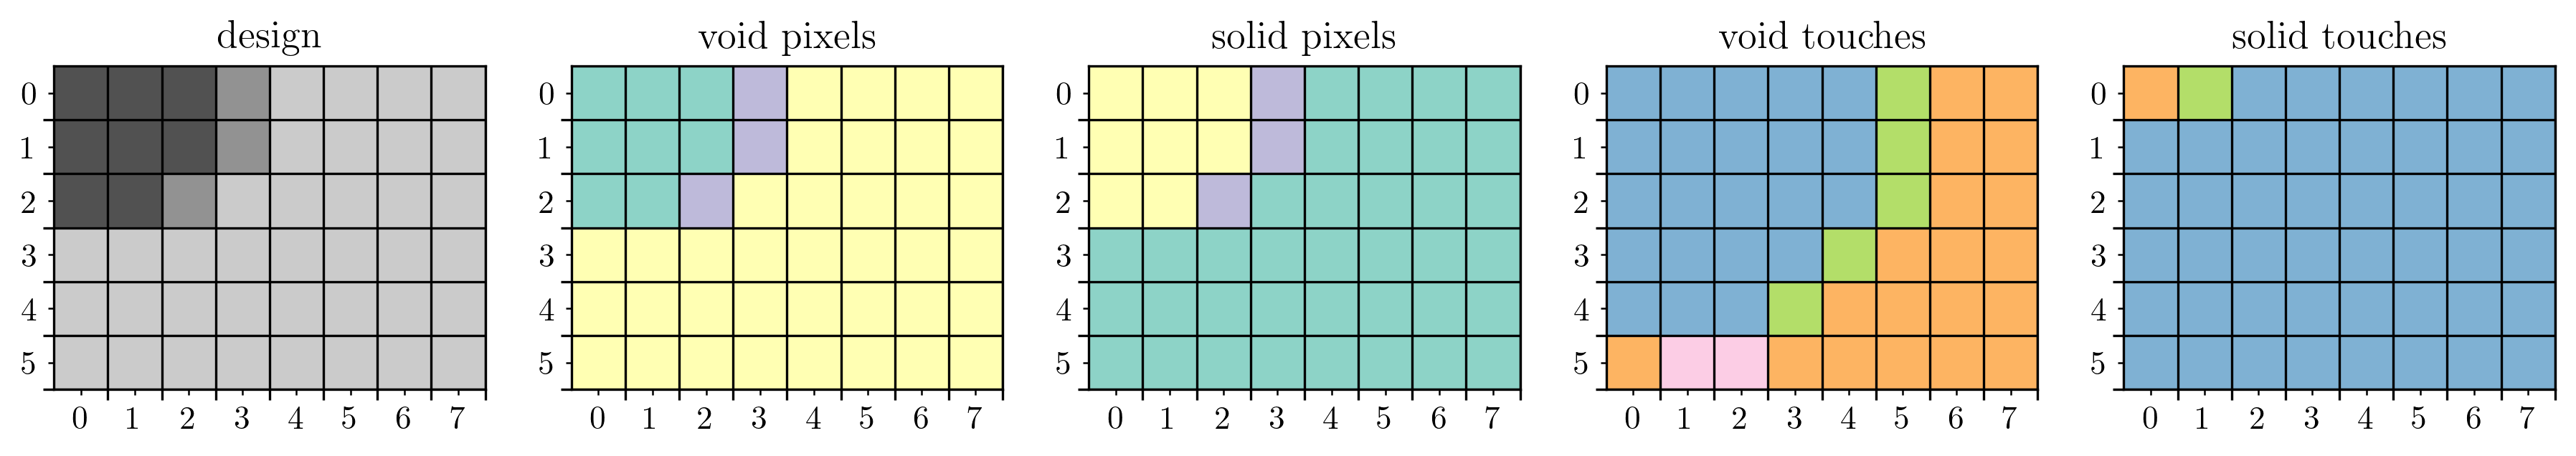

In [ ]:
step9 = lambda: add_void_touch(step8(), my_brush, (5, 0))
step9()

Design(void_pixels=Array([[3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 3, 5, 4, 4, 4, 4],
       [3, 3, 5, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 4, 5, 3, 3, 3, 3],
       [4, 4, 5, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8,  8, 10,  9,  9],
       [ 8,  8,  8,  8, 10,  9,  9,  9],
       [ 8,  8,  8, 10,  9,  9,  9,  9],
       [ 9,  9,  9,  9,  9,  9,  9,  9]], dtype=uint8), solid_touches=Array([[ 9, 10,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8],
       [ 8,  8,  8,  8,  8,  8,  8,  8]], dtype=uint8))

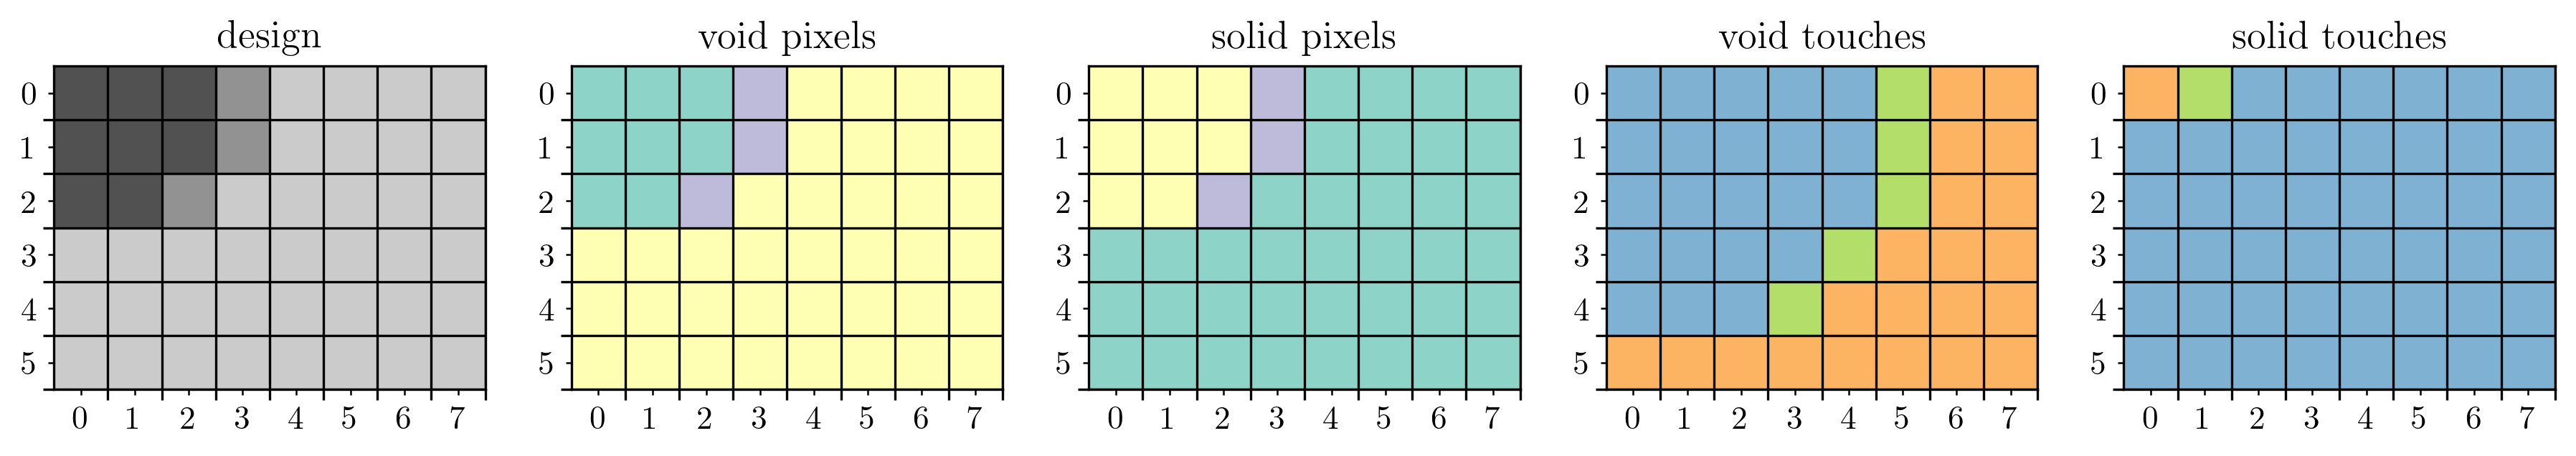

In [ ]:
step10 = lambda: take_free_void_touches(step9(), my_brush)
step10()

Design(void_pixels=Array([[3, 3, 3, 6, 4, 4, 4, 4],
       [3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 6, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 3, 3, 3, 3, 3],
       [4, 4, 4, 3, 3, 3, 3, 3],
       [4, 4, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[ 8,  8,  8,  8,  8, 11,  9,  9],
       [ 8,  8,  8,  8,  8, 11,  9,  9],
       [ 8,  8,  8,  8,  8,  9,  9,  9],
       [ 8,  8,  8,  8, 11,  9,  9,  9],
       [ 8,  8,  8, 11,  9,  9,  9,  9],
       [ 9,  9,  9,  9,  9,  9,  9,  9]], dtype=uint8), solid_touches=Array([[9, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8]], dtype=uint8))

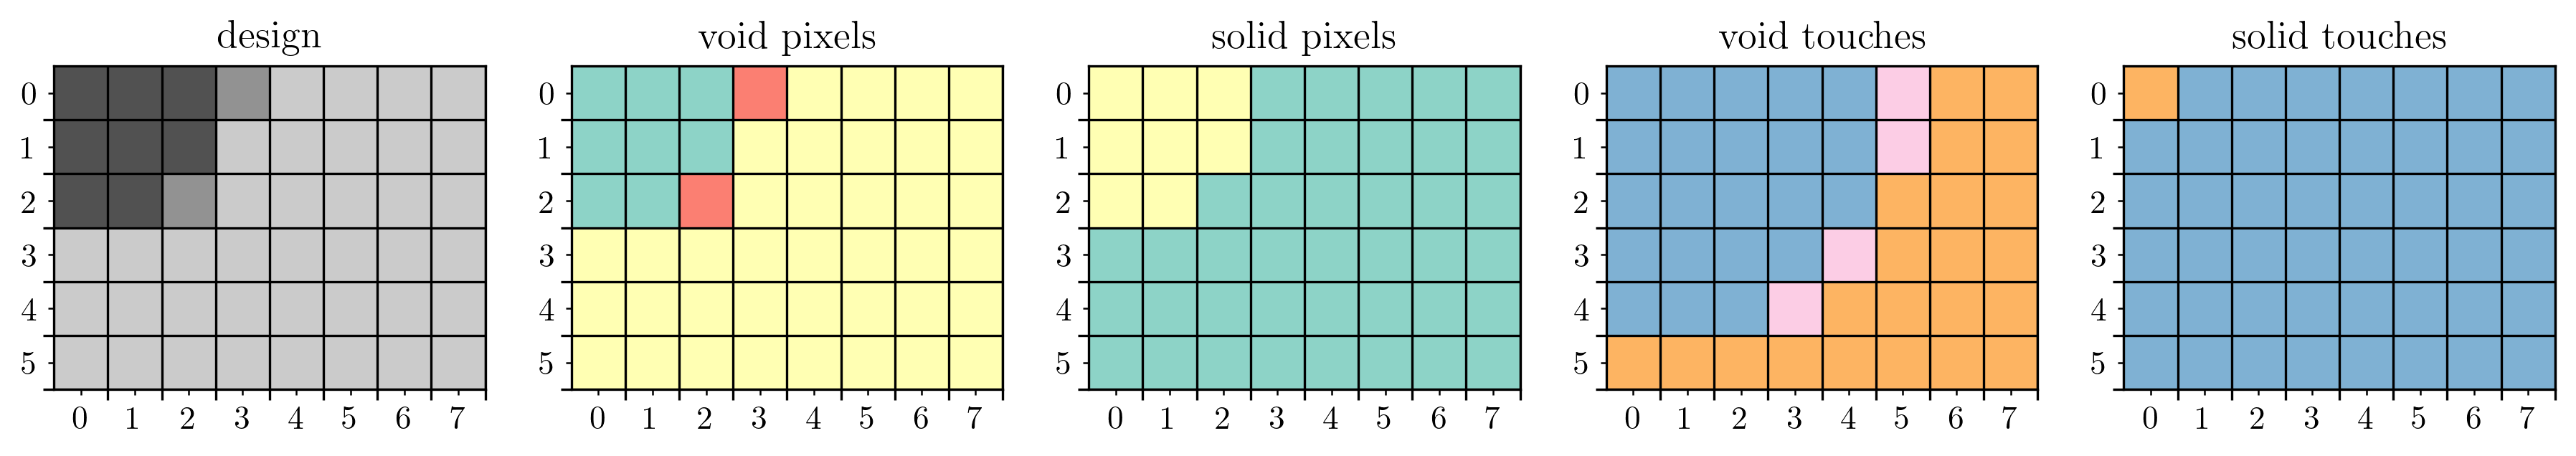

In [ ]:
step11 = lambda: add_void_touch(step10(), my_brush, (2, 5))
step11()

Design(void_pixels=Array([[3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 3, 4, 4, 4, 4, 4],
       [3, 3, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4],
       [4, 4, 4, 4, 4, 4, 4, 4]], dtype=uint8), solid_pixels=Array([[4, 4, 4, 3, 3, 3, 3, 3],
       [4, 4, 4, 3, 3, 3, 3, 3],
       [4, 4, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 3, 3]], dtype=uint8), void_touches=Array([[8, 8, 8, 8, 8, 9, 9, 9],
       [8, 8, 8, 8, 8, 9, 9, 9],
       [8, 8, 8, 8, 8, 9, 9, 9],
       [8, 8, 8, 8, 9, 9, 9, 9],
       [8, 8, 8, 9, 9, 9, 9, 9],
       [9, 9, 9, 9, 9, 9, 9, 9]], dtype=uint8), solid_touches=Array([[9, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8],
       [8, 8, 8, 8, 8, 8, 8, 8]], dtype=uint8))

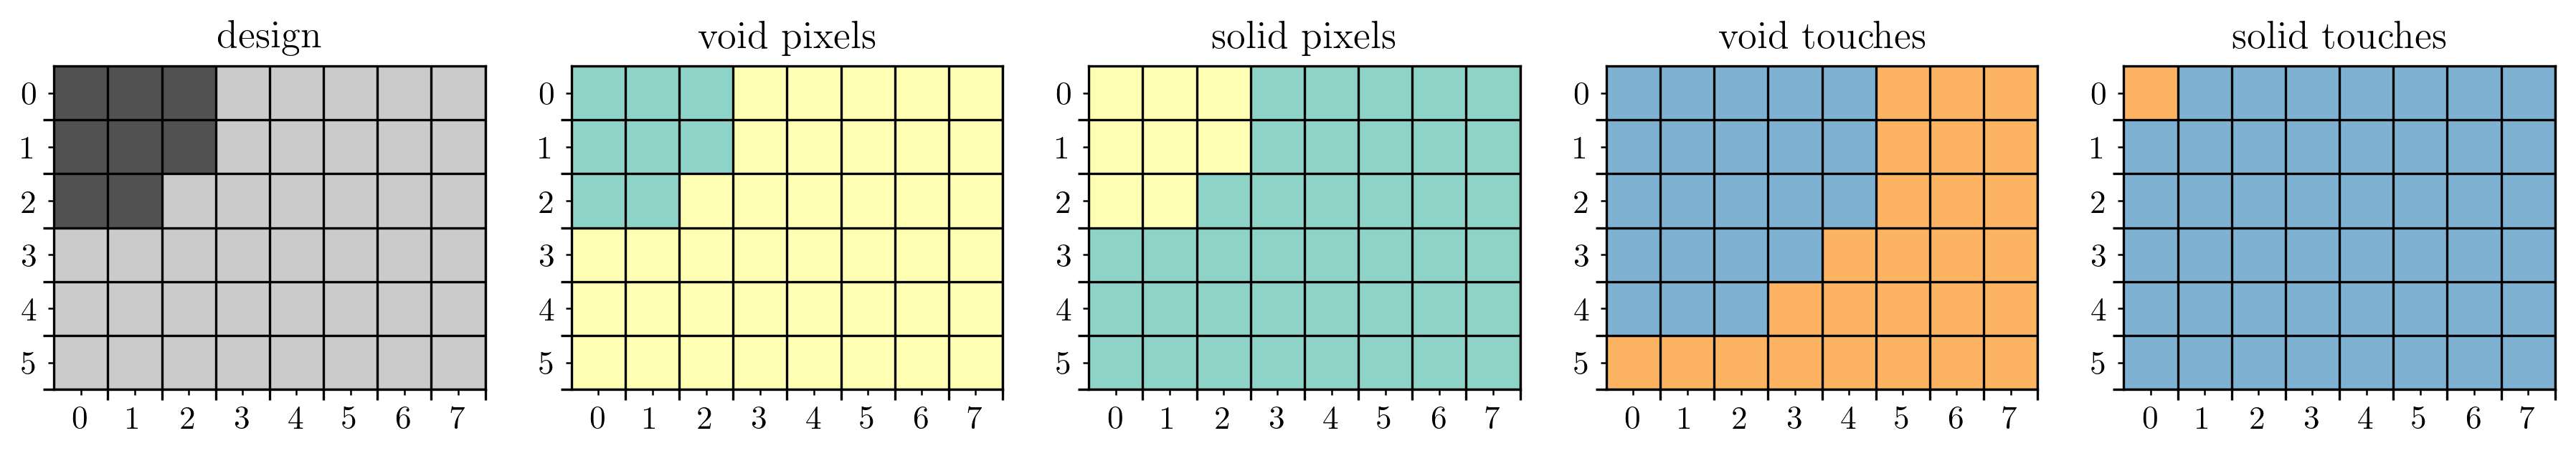

In [ ]:
step12 = lambda: take_free_void_touches(step11(), my_brush)
step12()